In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 19

In [3]:
def make_tridiagonal(n, a, b, c):
    diag = np.diag(b * np.ones(n))
    sub_diag = np.diag(a * np.ones(n-1), -1)
    sup_diag = np.diag(c * np.ones(n-1), 1)
    return sub_diag + diag + sup_diag

In [4]:
def richardson_test(n, m, k, alpha):
    A = make_tridiagonal(n, -1, 2, -1)
    error = 0
    for _ in range(m):
        u_0 = np.random.rand(n)
        u_sol = np.random.rand(n)
        u = u_0.copy()
        b = A @ u_sol
        for _ in range(k):
            u = u + alpha * (b - A @ u)
        error += np.linalg.norm(u - u_sol) / np.linalg.norm(u_0 - u_sol)
    return error / m 

Endpoint: 0.5000012312388665


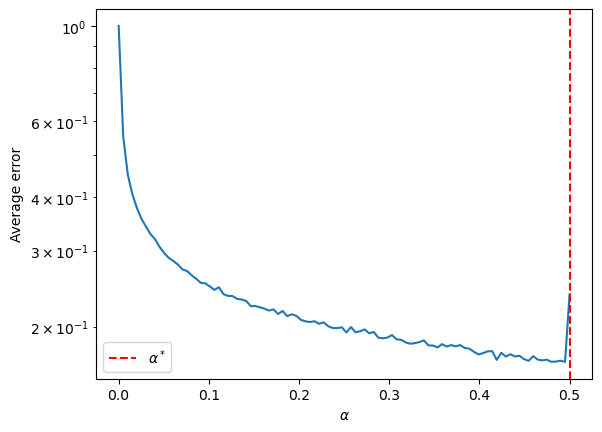

In [ ]:
n = 100
endpoint = 1 / (1 + np.cos(np.pi / (n+1)))
print(f"Endpoint: {endpoint}")
optimal_alpha = 1/2
alphas = np.linspace(0, endpoint, 100)
errors_richardson = [richardson_test(n, 100, 10, alpha) for alpha in alphas]
plt.semilogy(alphas, errors_richardson)
plt.axvline(optimal_alpha, color='red', linestyle='--', label=r'$\alpha^*$')
plt.xlabel(r'$\alpha$')
plt.ylabel('Average error')
plt.legend()
plt.show() 

# Problem 20

Algorithm which avoids multiplying with A twice

In [33]:
def make_spd_matrix(n, condition_number=2):
    Q, _ = np.linalg.qr(np.random.randn(n, n))
    
    eigvals = np.linspace(1, condition_number, n)
    D = np.diag(eigvals)

    A = Q @ D @ Q.T
    return A


def steepest_gradient_descent(A, b, x0, tol=1e-16, max_iter=10000, verbose=True):
    x = [x0]
    r = b - A @ x[-1]

    for iter_count in range(max_iter):
        Ar = A @ r
        alpha = (r.T @ r) / ( r.T @ Ar ) 
        x.append(x[-1] + alpha * r)
        if np.linalg.norm(r) < tol:
            if verbose:
                print(f"Converged in {iter_count} iterations.")
            return np.array(x)
        r = r - alpha * Ar
    if verbose:
        print(f"Did not converge in {max_iter} iterations.")
    return np.array(x)

In [28]:
n = 1000


A = make_spd_matrix(n, condition_number=2)

sol = np.random.rand(n)
b = A @ sol
x0 = np.random.rand(n)

x = steepest_gradient_descent(A, b, x0)
errors = x - sol

Converged in 33 iterations.


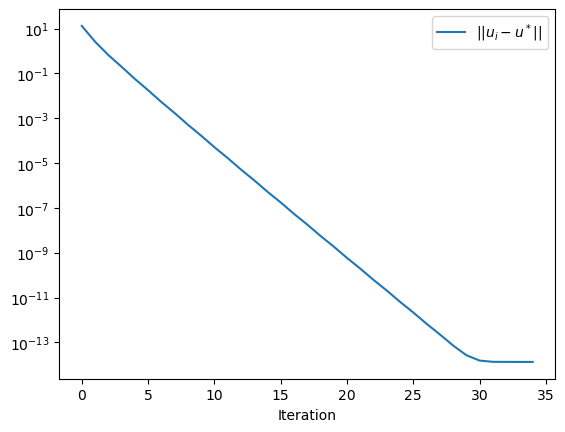

In [29]:
plt.semilogy(np.linalg.norm(errors, axis=1), label=r'$||u_i - u^*||$')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [26]:
n = 100
A = make_tridiagonal(n, -1, 2, -1)
m = 100
k = 10

error = 0

for _ in range(m):
        u_0 = np.random.rand(n)
        u_sol = np.random.rand(n)
        b = A @ u_sol
        
        u = steepest_gradient_descent(A, b, u_0, max_iter=k, verbose=False)
        e_k = np.linalg.norm(u[-1] - u_sol)
        e_0 = np.linalg.norm(u[0] - u_sol)

        error += e_k / e_0
error /= m
print(f"Average error: {error}")
print(f"Minimal average error with Richardson: {np.min(errors_richardson)}")
    

Average error: 0.2897158371089294
Minimal average error with Richardson: 0.13987100078692158


# Problem 22

In [40]:
n = 100

A = make_spd_matrix(n, condition_number=100)
L = np.linalg.cholesky(A)
sol = np.random.rand(n)
b = A @ sol
x0 = np.random.rand(n)

x = steepest_gradient_descent(A, b, x0)

errors = x - sol
residuals = b - [A @ x[i] for i in range(len(x))]

errors_l2 = np.linalg.norm(errors, axis=1, ord=2)
errors_inf = np.linalg.norm(errors, axis=1, ord=np.inf)
# Compute sqrt(x^T A x) by computing 2-norm of L.T @ x with LL^T = A
errors_A_norm = np.linalg.norm([L.T @ errors[i] for i in range(len(x))], axis=1, ord=2)
residuals_l2 = np.linalg.norm(residuals, axis=1)


Converged in 1785 iterations.


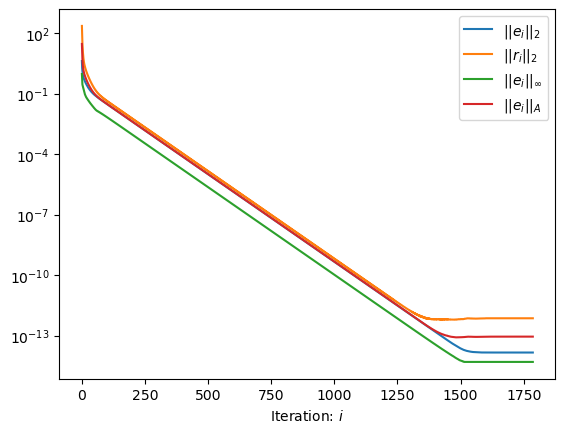

In [41]:
plt.semilogy(errors_l2, label=r'$||e_i||_2$')
plt.semilogy(residuals_l2, label=r'$||r_i||_2$')
plt.semilogy(errors_inf, label=r'$||e_i||_\infty$')
plt.semilogy(errors_A_norm, label=r'$||e_i||_A$')
plt.xlabel('Iteration: $i$')
plt.legend()
plt.show()

# Problem 23

In [53]:
def make_preconditioner(n, k):
    Q = make_tridiagonal(n,1,0,1)
    return np.sum([1/2**(i+1) * np.linalg.matrix_power(Q,i) for i in range(k+1)], axis=0) 

In [59]:
n = 100
k = 20
A = make_tridiagonal(n, -1, 2, -1)
u0 = np.random.rand(n)
sol = np.random.rand(n)
b = A @ sol

A_tilde = lambda k: make_preconditioner(n, k) @ A
b_tilde = lambda k: make_preconditioner(n, k) @ b


In [62]:
ratios = []
for k in range(0, k+1):
    x = steepest_gradient_descent(A_tilde(k), b_tilde(k), u0, max_iter=1, verbose=False)
    e0 = np.linalg.norm(x[0] - sol)
    e1 = np.linalg.norm(x[1] - sol)
    ratio = e1 / e0
    ratios.append(ratio)


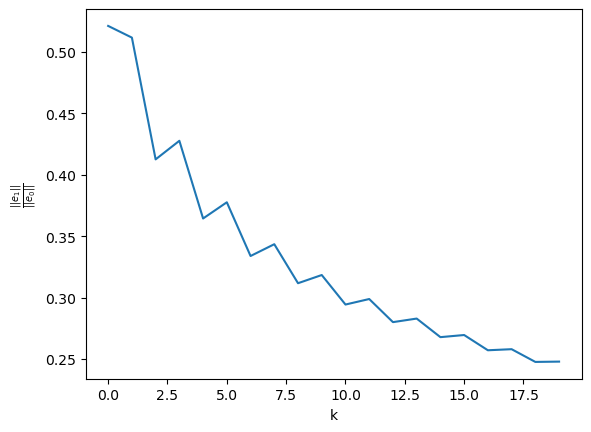

In [63]:
plt.plot(range(0, k+1), ratios)
plt.xlabel('k')
plt.ylabel(r'$\frac{||e_1||}{||e_0||}$')
plt.show()